<a href="https://colab.research.google.com/github/neil-vqa/Stock-price-trend-forecast/blob/master/univar_time_series_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import keras
import pandas as pd
import pandas_datareader as dr
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
stocks = ['AMZN']

df = dr.data.get_data_yahoo(stocks,start='2008-01', end='2018-12')
df.head()

Attributes,High,Low,Open,Close,Volume,Adj Close
Symbols,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,,
2008-01-02,97.430000,94.699997,95.349998,96.250000,13858700,96.250000
2008-01-03,97.250000,94.519997,96.059998,95.209999,9122500,95.209999
2008-01-04,93.400002,88.500000,93.260002,88.790001,10270000,88.790001
2008-01-07,90.570000,85.470001,88.620003,88.820000,9981600,88.820000
2008-01-08,91.830002,86.930000,87.550003,87.879997,12283300,87.879997


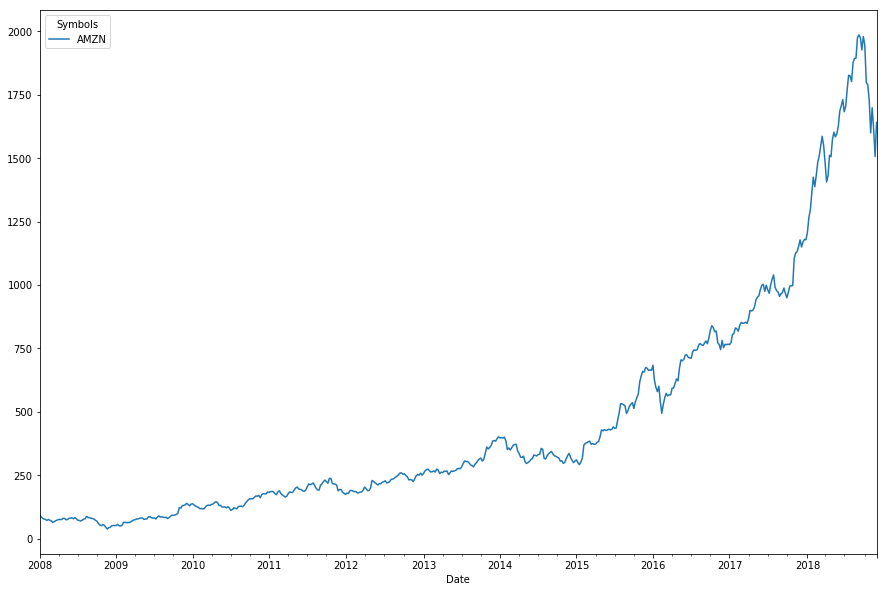

In [0]:
rs_data = df['Close'].resample('W').mean()
rs_data.plot(figsize=(15,10));

In [0]:
rs_data.tail()

Symbols,AMZN
Date,
2018-11-04,1599.674023
2018-11-11,1698.688037
2018-11-18,1615.976001
2018-11-25,1506.635010
2018-12-02,1640.847998


In [0]:
rs_data.shape

(570, 1)

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
sc_data = scaler.fit_transform(rs_data)

In [0]:
train_size = int(len(sc_data) * 0.80)
test_size = len(sc_data) - train_size
train_data, test_data = sc_data[0:train_size,:], sc_data[train_size:len(rs_data),:]

In [0]:
train_data_gen = keras.preprocessing.sequence.TimeseriesGenerator(train_data, train_data,
                               length=10, sampling_rate=1,stride=1,
                               batch_size=3)

In [0]:
test_data_gen = keras.preprocessing.sequence.TimeseriesGenerator(test_data, test_data,
                               length=10, sampling_rate=1,stride=1,
                               batch_size=1)

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(20, input_shape=(10, 1)))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1))

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [0]:
model.fit_generator(train_data_gen, epochs=50)

In [0]:
model.evaluate_generator(test_data_gen)

In [0]:
testPredict = model.predict_generator(test_data_gen)
testPredictor = scaler.inverse_transform(testPredict)
testOrig = scaler.inverse_transform(sc_data[train_size + 10:len(rs_data),:])

In [0]:
preds = [y for y in testPredictor]
acts = [y for y in testOrig]

In [0]:
print(len(preds))
print(len(acts))

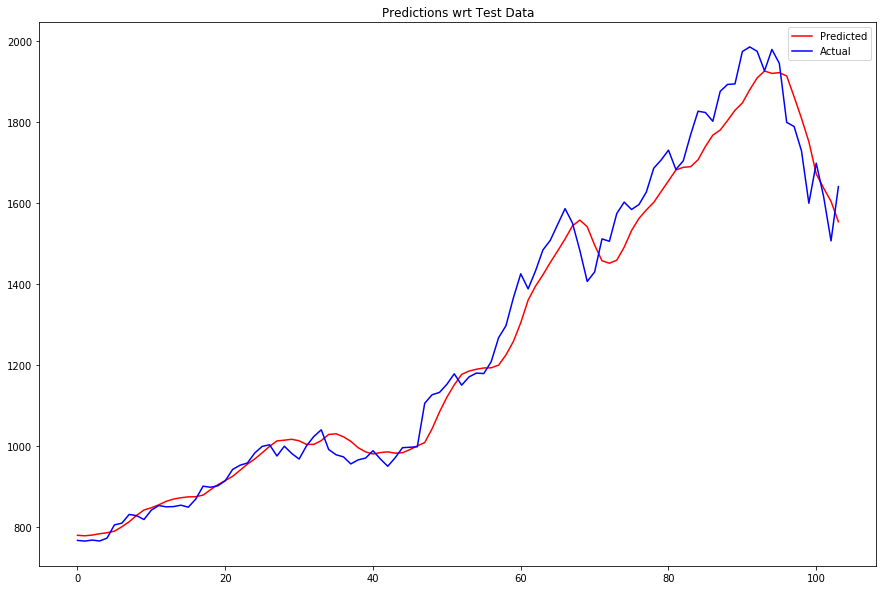

In [0]:
plt.figure(figsize=(15,10))
plt.plot(preds, color='red', label='Predicted')
plt.plot(acts, color='blue', label='Actual')
plt.title('Predictions wrt Test Data')
plt.legend()
plt.show()

In [0]:
trainPredict = model.predict_generator(train_data_gen)
trainPredictor = scaler.inverse_transform(trainPredict)
trainOrig = scaler.inverse_transform(sc_data[10:train_size,:])

In [0]:
t_preds = [y for y in trainPredictor]
t_acts = [y for y in trainOrig]

In [0]:
print(len(t_preds))
print(len(t_acts))

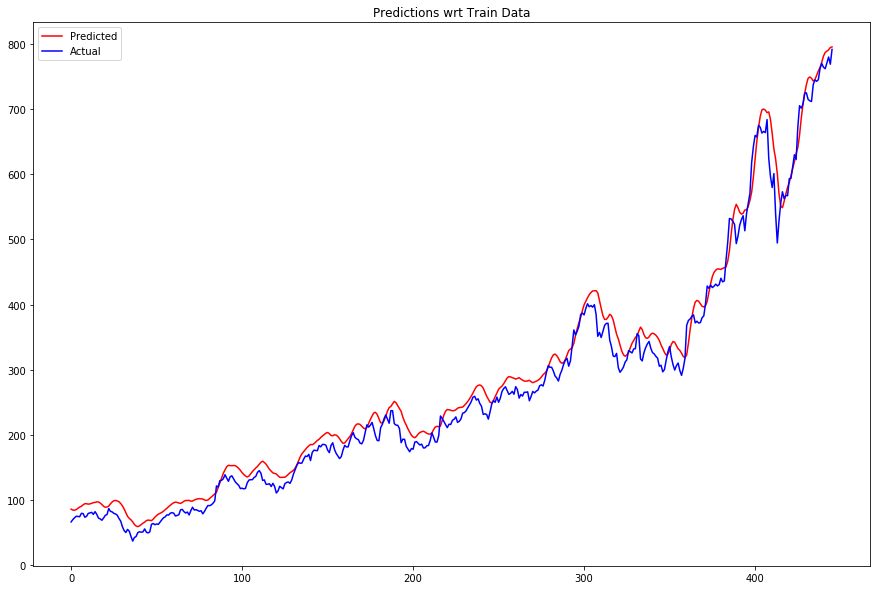

In [0]:
plt.figure(figsize=(15,10))
plt.plot(t_preds, color='red', label='Predicted')
plt.plot(t_acts, color='blue', label='Actual')
plt.title('Predictions wrt Train Data')
plt.legend()
plt.show()

In [0]:
full_preds = t_preds + preds
full_acts =  t_acts + acts

print(len(full_preds))
print(len(full_acts))

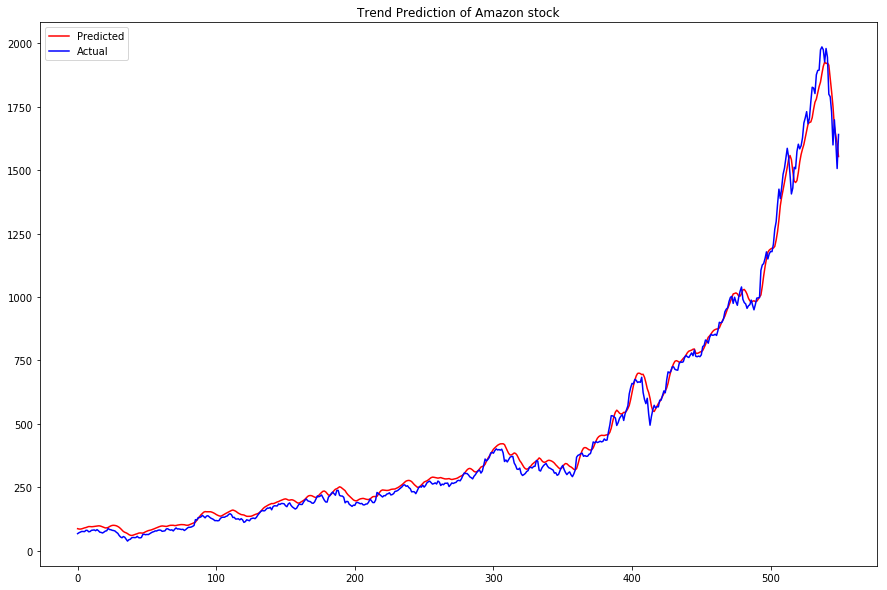

In [0]:
plt.figure(figsize=(15,10))
plt.plot(full_preds, color='red', label='Predicted')
plt.plot(full_acts, color='blue', label='Actual')
plt.title('Trend Prediction of Amazon stock')
plt.legend()
plt.show()